# All The reports and comments are here alongside the code just to keep everything in one place

# Q-Learning for flagged maze
- **Actions:** Actions are simply going LEFT, RIGHT, UP & DOWN only and only if we step into a `FLAG` or `WAY` or `TARGET`. **Note that stepping into a `BLOCK` is undefined just as stepping out of board is.** 
- **State**: States are simply the coordinates of the agent in the board and what type of block it is in(`WAY` or `FLAG` or ...) **AND** number of flags visited so far **AND** reward got so far.
- **Rewards**: Rewards are just as written in the first cell in constants. And as we've explaned later visiting any block for nth time(n != 1) has reward of `n*REVISITED_REWARD`
- **Goal State**: The goal state is to reach the `TARGET` with the maximum reward gathered and visited all **7 flags**
First we define some constants and the initial board of the maze 



- One way to reduce the number of states is as we explaned to undefine moving to `BLOCK` places. This will reduce a lot of states and also moves.

In [1]:
import copy
import numpy as np
from typing import Tuple

RUN_ALL = True

RIGHT = 'R'
LEFT = 'L'
UP = 'U'
DOWN = 'D'

WAY = 'W'
BLOCK = 'B'
TARGET = 'T'
FLAG = 'F'
REVISITED = 'R'

WAY_REWARD = -1
REVISITED_REWARD = -2
FLAG_REWARD = 30
TARGET_REWARD = 300

BASE_REWARDS = {
    WAY: WAY_REWARD,
    TARGET: TARGET_REWARD,
    FLAG: FLAG_REWARD,
    REVISITED: REVISITED_REWARD
}

ACTIONS = (RIGHT, LEFT, UP, DOWN)
BLOCK_TYPES = (WAY, TARGET, FLAG, REVISITED) # we don't need 'B' here

initBoard = [['W', 'B', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
             ['W', 'W', 'W', 'F', 'W', 'B', 'W', 'W', 'W', 'W'],
             ['F', 'W', 'W', 'W', 'W', 'B', 'F', 'W', 'W', 'W'],
             ['B', 'B', 'W', 'B', 'B', 'W', 'B', 'W', 'W', 'W'],
             ['W', 'F', 'B', 'W', 'B', 'F', 'B', 'B', 'B', 'W'],
             ['W', 'W', 'B', 'W', 'B', 'W', 'W', 'W', 'W', 'W'],
             ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
             ['W', 'F', 'W', 'W', 'W', 'W', 'B', 'B', 'B', 'B'],
             ['W', 'B', 'B', 'B', 'B', 'B', 'W', 'W', 'W', 'W'],
             ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'B', 'F', 'T']]

# All The reports and comments are here beside the code just to keep everything in one place

## We'll try to keep everything object oriented. So here we define a class for environment. 
#### It will hold a new copy of the board at the start of each episode and also will keep track of all the places we've visited and also all the flags we've visited.

In [2]:
class Environment:
    def __init__(self) -> None:
        self._flagsVisited = set()
        self.initBourd()
        self.initVisitedFlags()
        self.initVisitedBlocks()

    def initVisitedFlags(self):
        self.visitedFlags = set()

    def initVisitedBlocks(self):
        self.visitedBlocks = dict()

    def initBourd(self):
        self.board = copy.deepcopy(initBoard)
    
    def addVisit(self, row: int, column: int) -> None:
        if (row, column) in self.visitedBlocks:
            self.visitedBlocks[row, column] += 1
        else:
            self.visitedBlocks[row, column] = 1
            
        if self.isFlag(row, column) and (row, column) not in self.visitedFlags:
            self.visitedFlags.add((row, column))
    
    def isFlag(self, row, column) -> bool:
        return self.board[row][column] == FLAG
    
    def isWay(self, row, column) -> bool:
        return self.board[row][column] == WAY
      
    def isTarget(self, row, column) -> bool:
        return self.board[row][column] == TARGET
    

### Just a simple function that checks that whether an agnent in `row` and `column` can take `action` in environment `env` or not
#### **Note that we treat `BLOCK`s just like any place out of the matrix of the board. Agent cannot go to a `BLOCK` as it cannot go out of board**

In [3]:
def checkAction(row: int, column: int, action: str) -> bool:
    if action == RIGHT:
        return column + 1 < len(initBoard[0]) and initBoard[row][column + 1] != BLOCK
    elif action == LEFT:
        return column - 1 >=0 and initBoard[row][column - 1] != BLOCK
    elif action == UP:
        return row - 1 >= 0 and initBoard[row - 1][column] != BLOCK
    elif action == DOWN:
        return row + 1 < len(initBoard) and initBoard[row + 1][column] != BLOCK
    else:
        raise Exception("Unknown action")
    
def getNextPosition(row: int, column: int, action: str):
    if checkAction(row, column, action) and action in ACTIONS:
        if action == RIGHT:
            return row, column + 1
        elif action == LEFT:
            return row, column - 1
        elif action == UP:
            return row - 1, column
        elif action == DOWN:
            return row + 1, column
        else:
            raise Exception("Unknown action")
    else:
        return -1, -1
    

### Here we create a class for a state that holds the `row`, `column` and `env`, It will also keep track of total awards gathered so far
#### It also has some useful functionalities like `addReward` and `move` and `action`

In [4]:
class State:
    # FLAG_VISIT_REWARD_RATE = 2
    def __init__(self, row, column, env: Environment):
        self.row = row
        self.column = column
        self.rewardSoFar = 0
        self.env = env

    def addReward(self, newReward: int): # add the reward to total rewards
        self.rewardSoFar += newReward

    def setReward(self, reward: int):
        self.rewardSoFar = reward

    def move(self, newRow: int, newColumn: int): # if it can move, it changes row and column
        if(0 <= newRow and newRow < len(self.env.board) and 0 <= newColumn and newColumn < len(self.env.board[0]) and self.env.board[newRow][newColumn] != BLOCK):
            self.row = newRow
            self.column = newColumn
        else:
            raise IndexError("The action will cause the agent to get out of the bourd or to a block point")
    
    def action(self, action: str): # if the action is OK and valid it takes it and move
        if(action in ACTIONS):
            if action == RIGHT:
                self.move(self.row, self.column + 1)
            elif action == LEFT:
                self.move(self.row, self.column - 1)
            elif action == UP:
                self.move(self.row - 1, self.column)
            else: # definitely DOWN
                self.move(self.row + 1, self.column)
        else:
            raise Exception(f"Unknown type of action: {action}")

    def __str__(self) -> str:
        return f"{self.row, self.column}"

## For the main Q Function we also created a `callable` class!
#### Since we'll have to try many factors and run several times we need to manage all these Q tables and stuff.,<br/> This class will hold the `__qTable` (q-table) and has an `update` method to update it.<br/> And to be complete we overloaded a `callable` to call the Q function related to this q-table 
## what what we keep in our table? 
#### since this a flagged maze and lots of scenarios may happen we need to know more than "where are we and what action to take". We also need to know that if we're at `row` and `column` and take some `action` to which type of block we'll go. So out entries in q-table will look like `(row, column, action, blockTypeWeWillGo)`.

In [5]:

ALPHA = 0.9
GAMMA = 0.25
# The object for Q function
# we decided to create a class for it to hold the info
class Q:

    def __init__(self) -> None:
        self.__qTable = dict()
        for i in range(len(initBoard)):
            for j in range(len(initBoard[0])):
                if initBoard[i][j] != BLOCK:        
                    for action in ACTIONS:
                        nextPosition = getNextPosition(i, j, action)
                        if nextPosition != (-1, -1):
                            nextBlockType = initBoard[nextPosition[0]][nextPosition[1]]
                            
                            self.__qTable[i, j, action, nextBlockType] = BASE_REWARDS[nextBlockType]
                            
                            self.__qTable[i, j, action, REVISITED] = REVISITED_REWARD                            
                            
    def getTable(self):
        return copy.deepcopy(self.__qTable)
    
    def update(self, 
               row: int,
               column: int, 
               action: str, 
               blockType: str,
               oldValue: int, 
               reward: int, 
               maxQ: int) -> None:
        
        # print(f"updated from {(row, column, action, blockType)} = {self.__qTable[row, column, action, blockType]} to ", end='')
        updatedValue = oldValue + ALPHA*(reward + GAMMA*maxQ - oldValue)
        self.__qTable[row, column, action, blockType] = updatedValue
        # print(f"{oldValue + ALPHA*(reward + GAMMA*maxQ - oldValue)}", end=' | ')
        
    def __call__(self, state: State, action: str, env: Environment) -> tuple[State, int]:
        nextState = copy.deepcopy(state)
        nextState.action(action)
        return self.__qTable[state.row, state.column, action, env.board[nextState.row][nextState.column]]
        
        

### Here we have some usefull functions used in the main algorithm:
- `chooseRandomAction`: will return a **valid** randomly choosen action based on the state and the environment.

- `getBestQ`: will take `state` and `env` and `q` function and will return what's the best policy(best action) based on q-table in `q` function and what will be its q-value

- `getReward`: simply return the reward based on the `row` and `column` we've stepped into in `env`
    - if we've stepped into `n`th flag we'll get `n*FLAG_REWARD`. This will encourage the engine to visite more flags on the way
    - if we've stepped into **target** or **way** we'll get `TARGET_REWARD` or `WAY_REWARD`
    - if we've stepped into a place that we're visiting for `n`th time we'll get `n*REVISIT_REWARD` (which will be negative and is a big punish!)

In [6]:

import random
def chooseRandomAction(state: State, env: Environment) -> str:
    row, column = state.row, state.column
    okay = False
    randomAction = None
    choices = list(ACTIONS)
    while not okay:
        randomAction = random.choice(choices)
        if checkAction(row, column, randomAction):
            okay = True
        choices.remove(randomAction)

    return randomAction

def getBestQ(state: State, env: Environment, q: Q) -> int:
    maxQ = -np.inf
    bestAction = None
    for action in ACTIONS:
        if checkAction(state.row, state.column, action):
            qValue = q(state, action, env)
            if(maxQ < qValue):
                maxQ = qValue
                bestAction = action
            maxQ = np.max([maxQ, qValue])
    return bestAction, maxQ

def getReward(row: int, column: int, env: Environment):
    if env.isFlag(row, column):
        return FLAG_REWARD * (len(env.visitedFlags)+1)
    if env.isTarget(row, column):
        return TARGET_REWARD
    if env.isWay(row, column):
        return WAY_REWARD
    if (row, column) in env.visitedBlocks: # visited
        return env.visitedBlocks[row, column] * REVISITED_REWARD
    


# The algorithm

### To have the algorithm run more efficiently we implement an idea: To maintain a balance between exploration and explotation. 
#### The idea is that when we want to start an episode we explote until where we've learned well and as we reach the area that we haven't learned well, we start to explore and learn. To do so, assume that we're about to run an episode `n` times. We'll **explote** in the first `n/5` steps(itteration) and **explore** in the next `4n/5` steps(itterations). **And to progress gradually, we run 1st episode 1 itteration, 2nd epidose 2 itterations and nth episode n itterations ..** 

## `Episode` class
#### In `Episode` class we keep track of each episode progress info.
- The `runNTimes` method will run this episode n times. Which will explote n/5 steps and explore 4n/5 steps as explaned above

- The `runOneItter` is the core of the algorithm and runs one itteration of the episode and return `True` if it has reached the target
### **Note that we also have a AWARD_LIMIT which is actually punish limit. Each episode will stop running whenever it "runs n steps" OR it gets rewards "less that this limit"**

In [7]:
AWARD_LIMIT = -300

class Episode:
    def __init__(self, qFunction: Q) -> None:
        self.env = Environment()
        self.state = State(0, 0, self.env)
        self.env.addVisit(0, 0)
        self.env.board[0][0] = REVISITED
        self.qFunction = qFunction
        
    def runNTimes(self, n: int):
        # print(f"------------------------A new Episode started that will run at most {n} itterations-----------------------------")
        
        # print("==============explotation==================")
            
        for itterNumber in range(n//5):
            if self.runOneItter(getBestQ(self.state, self.env, self.qFunction)[0]) or self.state.rewardSoFar < AWARD_LIMIT:
                return
        # print("==============exploration==================")
        for itterNumber in range(4*n//5):
            if self.runOneItter(chooseRandomAction(self.state, self.env)) or self.state.rewardSoFar < AWARD_LIMIT:
                return
            
        
    def runOneItter(self, action):
        # print(f"going {action}", end=' | ')
        
        nextState = copy.deepcopy(self.state)
        nextState.action(action)

        
        # print(f"to {nextState.row, nextState.column}", end= " | ")
        
        oldQValue = self.qFunction(self.state, action, self.env)
        oldBlockType = self.env.board[nextState.row][nextState.column]
        
        reward = getReward(nextState.row, nextState.column, self.env)
        nextState.addReward(reward)
        # print(f"reward so far: {self.state.rewardSoFar}", end= " | ")
        # print(f"Reward {reward}", end=' | ')
        
        # update env
        self.env.addVisit(nextState.row, nextState.column)
        self.env.board[nextState.row][nextState.column] = REVISITED
        
        bestQ = getBestQ(nextState, self.env, self.qFunction)                
        
        self.qFunction.update(self.state.row, self.state.column, action, oldBlockType, oldQValue, reward, bestQ[1])
        
        self.state = nextState
        if (self.state.row, self.state.column) == (len(initBoard)-1, len(initBoard[0])-1):
            # print()
            return True
            
        
        # print()
        return False
        

##### 2 simple function 
- `runAlgorithm`: runs the algorithm with the stategy explaned above with `n` episodes

- `reportResults`: reports the result of the algorimth after learning its q-table. It takes the `q` object and follow its table until it reaches the target.

In [8]:
def runAlgorithm(n) -> Q:
    qFunction = Q()
    for episodeNum in range(n):
        episode = Episode(qFunction)
        episode.runNTimes(episodeNum+1)    
    return qFunction
       

def reportResult(q: Q):
    env = Environment()
    state = State(0, 0, env)
    print(f"getting reward {getReward(state.row, state.column, env)}", end=" ") 
    env.addVisit(0, 0)
    env.board[state.row][state.column] = REVISITED
    limit = 60 # the actual path length is 51
    rewardSoFar = -1 # including starging point
    qValueSoFar = 0
    numOfFlagsVisited = 0
    for stepNum in range(limit):
        action, maxQ = getBestQ(state, env, q)
        
        qValueSoFar += maxQ
        
        print(f"[#{stepNum+1}] {state} going {action} to:")
        state.action(action)
        
        rewardSoFar += getReward(state.row, state.column, env)
        print(f"getting reward {getReward(state.row, state.column, env)}", end=" ")
        
        if(env.isFlag(state.row, state.column)):
            numOfFlagsVisited += 1
            
        env.addVisit(state.row, state.column)
        env.board[state.row][state.column] = REVISITED
        
        if (state.row, state.column) == (len(initBoard)-1, len(initBoard[0])-1):
            print(state)
            print(f"Finished with path length:{stepNum}, flags visited: {numOfFlagsVisited}, Total reward: {rewardSoFar}, TotalQValueEarned: {qValueSoFar}")
            break
    else:
        print(f"Failed!")

# Time to run the algorithm

Run 700 episodes such that nth episode will run n itterations
One of the best paramter set is (alpha = 0.9, gamma = 0.25) as we set above

--------------------------------------------------------------------
Testing with 
- gamma = 0.5
- alpha = 0.9

In [9]:
if RUN_ALL:
    q = runAlgorithm(700)
    reportResult(q)

getting reward -1 [#1] (0, 0) going D to:
getting reward -1 [#2] (1, 0) going D to:
getting reward 30 [#3] (2, 0) going R to:
getting reward -1 [#4] (2, 1) going R to:
getting reward -1 [#5] (2, 2) going U to:
getting reward -1 [#6] (1, 2) going R to:
getting reward 60 [#7] (1, 3) going R to:
getting reward -1 [#8] (1, 4) going U to:
getting reward -1 [#9] (0, 4) going R to:
getting reward -1 [#10] (0, 5) going R to:
getting reward -1 [#11] (0, 6) going D to:
getting reward -1 [#12] (1, 6) going D to:
getting reward 90 [#13] (2, 6) going R to:
getting reward -1 [#14] (2, 7) going R to:
getting reward -1 [#15] (2, 8) going D to:
getting reward -1 [#16] (3, 8) going R to:
getting reward -1 [#17] (3, 9) going D to:
getting reward -1 [#18] (4, 9) going D to:
getting reward -1 [#19] (5, 9) going L to:
getting reward -1 [#20] (5, 8) going L to:
getting reward -1 [#21] (5, 7) going L to:
getting reward -1 [#22] (5, 6) going L to:
getting reward -1 [#23] (5, 5) going U to:
getting reward 120 [

Results:
- outcome: sucess
- time: 22.6s
--------------------------------------------------------------------------------------

----------------------------------------------------------------
Testing with 
- gamma = 0.5
- alpha = 0.9

In [10]:
if RUN_ALL:
    GAMMA = 0.5
    q = runAlgorithm(700)
    reportResult(q)


getting reward -1 [#1] (0, 0) going D to:
getting reward -1 [#2] (1, 0) going D to:
getting reward 30 [#3] (2, 0) going R to:
getting reward -1 [#4] (2, 1) going R to:
getting reward -1 [#5] (2, 2) going R to:
getting reward -1 [#6] (2, 3) going U to:
getting reward 60 [#7] (1, 3) going R to:
getting reward -1 [#8] (1, 4) going U to:
getting reward -1 [#9] (0, 4) going R to:
getting reward -1 [#10] (0, 5) going R to:
getting reward -1 [#11] (0, 6) going D to:
getting reward -1 [#12] (1, 6) going D to:
getting reward 90 [#13] (2, 6) going R to:
getting reward -1 [#14] (2, 7) going U to:
getting reward -1 [#15] (1, 7) going R to:
getting reward -1 [#16] (1, 8) going R to:
getting reward -1 [#17] (1, 9) going D to:
getting reward -1 [#18] (2, 9) going D to:
getting reward -1 [#19] (3, 9) going D to:
getting reward -1 [#20] (4, 9) going D to:
getting reward -1 [#21] (5, 9) going L to:
getting reward -1 [#22] (5, 8) going L to:
getting reward -1 [#23] (5, 7) going L to:
getting reward -1 [#

Results:
- outcome: sucess **but 2 extra moves** (Not optimal)
- time: 28.4s
-------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------
Testing with 
- gamma = 1
- alpha = 0.9

In [11]:
if RUN_ALL:
    GAMMA = 1
    q = runAlgorithm(800)
    reportResult(q)


getting reward -1 [#1] (0, 0) going D to:
getting reward -1 [#2] (1, 0) going R to:
getting reward -1 [#3] (1, 1) going R to:
getting reward -1 [#4] (1, 2) going U to:
getting reward -1 [#5] (0, 2) going R to:
getting reward -1 [#6] (0, 3) going D to:
getting reward 30 [#7] (1, 3) going R to:
getting reward -1 [#8] (1, 4) going U to:
getting reward -1 [#9] (0, 4) going R to:
getting reward -1 [#10] (0, 5) going R to:
getting reward -1 [#11] (0, 6) going D to:
getting reward -1 [#12] (1, 6) going R to:
getting reward -1 [#13] (1, 7) going R to:
getting reward -1 [#14] (1, 8) going D to:
getting reward -1 [#15] (2, 8) going D to:
getting reward -1 [#16] (3, 8) going R to:
getting reward -1 [#17] (3, 9) going D to:
getting reward -1 [#18] (4, 9) going D to:
getting reward -1 [#19] (5, 9) going L to:
getting reward -1 [#20] (5, 8) going L to:
getting reward -1 [#21] (5, 7) going L to:
getting reward -1 [#22] (5, 6) going L to:
getting reward -1 [#23] (5, 5) going D to:
getting reward -1 [#

Results:
- outcome: Failiar
- time: 1m 1.5s
--------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------
Testing with 
- gamma = 0.25
- alpha = 0.8

### GAMMA: 
As we saw, the higher the GAMMA is, the more effect the **best next Qs** has and makes the algorithm takes longer and also not give the optimal answer sometimes.
If it gets so high it may even cause the algorithm now converge and fail to reach the target


In [12]:
if RUN_ALL:
    GAMMA = 0.25
    ALPHA = 0.8
    q = runAlgorithm(700)
    reportResult(q)

getting reward -1 [#1] (0, 0) going D to:
getting reward -1 [#2] (1, 0) going D to:
getting reward 30 [#3] (2, 0) going R to:
getting reward -1 [#4] (2, 1) going R to:
getting reward -1 [#5] (2, 2) going U to:
getting reward -1 [#6] (1, 2) going R to:
getting reward 60 [#7] (1, 3) going R to:
getting reward -1 [#8] (1, 4) going U to:
getting reward -1 [#9] (0, 4) going R to:
getting reward -1 [#10] (0, 5) going R to:
getting reward -1 [#11] (0, 6) going D to:
getting reward -1 [#12] (1, 6) going D to:
getting reward 90 [#13] (2, 6) going R to:
getting reward -1 [#14] (2, 7) going R to:
getting reward -1 [#15] (2, 8) going D to:
getting reward -1 [#16] (3, 8) going R to:
getting reward -1 [#17] (3, 9) going D to:
getting reward -1 [#18] (4, 9) going D to:
getting reward -1 [#19] (5, 9) going L to:
getting reward -1 [#20] (5, 8) going L to:
getting reward -1 [#21] (5, 7) going L to:
getting reward -1 [#22] (5, 6) going L to:
getting reward -1 [#23] (5, 5) going U to:
getting reward 120 [

Results:
- outcome: sucess **but two extra moves**
- time: 28.7s
--------------------------------------------------------------------------------------

---------------------------------------------------------------------------------
Testing with 
- gamma = 0.25
- alpha = 0.7

In [13]:
if RUN_ALL:
    ALPHA = 0.7
    q = runAlgorithm(700)
    reportResult(q)

getting reward -1 [#1] (0, 0) going D to:
getting reward -1 [#2] (1, 0) going D to:
getting reward 30 [#3] (2, 0) going R to:
getting reward -1 [#4] (2, 1) going R to:
getting reward -1 [#5] (2, 2) going U to:
getting reward -1 [#6] (1, 2) going R to:
getting reward 60 [#7] (1, 3) going R to:
getting reward -1 [#8] (1, 4) going U to:
getting reward -1 [#9] (0, 4) going R to:
getting reward -1 [#10] (0, 5) going R to:
getting reward -1 [#11] (0, 6) going D to:
getting reward -1 [#12] (1, 6) going D to:
getting reward 90 [#13] (2, 6) going R to:
getting reward -1 [#14] (2, 7) going R to:
getting reward -1 [#15] (2, 8) going R to:
getting reward -1 [#16] (2, 9) going D to:
getting reward -1 [#17] (3, 9) going D to:
getting reward -1 [#18] (4, 9) going D to:
getting reward -1 [#19] (5, 9) going L to:
getting reward -1 [#20] (5, 8) going L to:
getting reward -1 [#21] (5, 7) going L to:
getting reward -1 [#22] (5, 6) going L to:
getting reward -1 [#23] (5, 5) going U to:
getting reward 120 [

Results:
- outcome: sucess
- time: 27.2s
--------------------------------------------------------------------------------------

----------------------------------------------------------------------------------
Testing with 
- gamma = 0.25
- alpha = 0.6

In [14]:
if RUN_ALL:
    ALPHA = 0.6
    q = runAlgorithm(700)
    reportResult(q)


getting reward -1 [#1] (0, 0) going D to:
getting reward -1 [#2] (1, 0) going D to:
getting reward 30 [#3] (2, 0) going R to:
getting reward -1 [#4] (2, 1) going R to:
getting reward -1 [#5] (2, 2) going R to:
getting reward -1 [#6] (2, 3) going U to:
getting reward 60 [#7] (1, 3) going R to:
getting reward -1 [#8] (1, 4) going U to:
getting reward -1 [#9] (0, 4) going R to:
getting reward -1 [#10] (0, 5) going R to:
getting reward -1 [#11] (0, 6) going D to:
getting reward -1 [#12] (1, 6) going D to:
getting reward 90 [#13] (2, 6) going R to:
getting reward -1 [#14] (2, 7) going R to:
getting reward -1 [#15] (2, 8) going D to:
getting reward -1 [#16] (3, 8) going R to:
getting reward -1 [#17] (3, 9) going D to:
getting reward -1 [#18] (4, 9) going D to:
getting reward -1 [#19] (5, 9) going L to:
getting reward -1 [#20] (5, 8) going L to:
getting reward -1 [#21] (5, 7) going L to:
getting reward -1 [#22] (5, 6) going L to:
getting reward -1 [#23] (5, 5) going U to:
getting reward 120 [

Results:
- outcome: sucess **but two extra moves**
- time: 29.5s
--------------------------------------------------------------------------------------

### ALPHA: 
As we saw, the lower the alpha is the more effect the old-Q-value will have and makes the algorithm takes longer and also not give the optimal answer sometimes


### Draw The Graph

In [15]:
import matplotlib.pyplot as plt
import networkx as nx


def drawGraph(table: dict[tuple: int]):
    fig = plt.figure(figsize=(25, 25))
    G = nx.DiGraph()
    added_edges = set()
    for key in table:
        row1, column1, action, blockType2 = key
        blockType1 = initBoard[row1][column1]
        row2, column2 = getNextPosition(row1, column1, action)
        if( ((row1, column1, blockType1) , (row2, column2, blockType2)) not in added_edges):
            G.add_edge(f"{row1},{column1},{blockType1}", f"{row2},{column2},{blockType2}", weight=round(table[key], 3))
    
        if( ((row1, column1, REVISITED) , (row2, column2, blockType2)) not in added_edges):
            G.add_edge(f"{row1},{column1},{blockType1}", f"{row2},{column2},{blockType2}", weight=round(table[key], 3))

    edges = [(u, v) for (u, v, d) in G.edges(data=True)]
    pos = nx.spring_layout(G) 
    
    nx.draw_networkx_nodes(G, pos, node_size=600)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=2)
    
    nx.draw_networkx_labels(G, pos, font_size=10)

    edge_labels = nx.get_edge_attributes(G, "weight")
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7)
    
    ax = plt.gca()
    ax.margins(0.08)
    ax.figure.set_size_inches(25, 25)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
        
        

In [16]:
ALPHA = 0.9
GAMMA = 0.25
q = runAlgorithm(700)


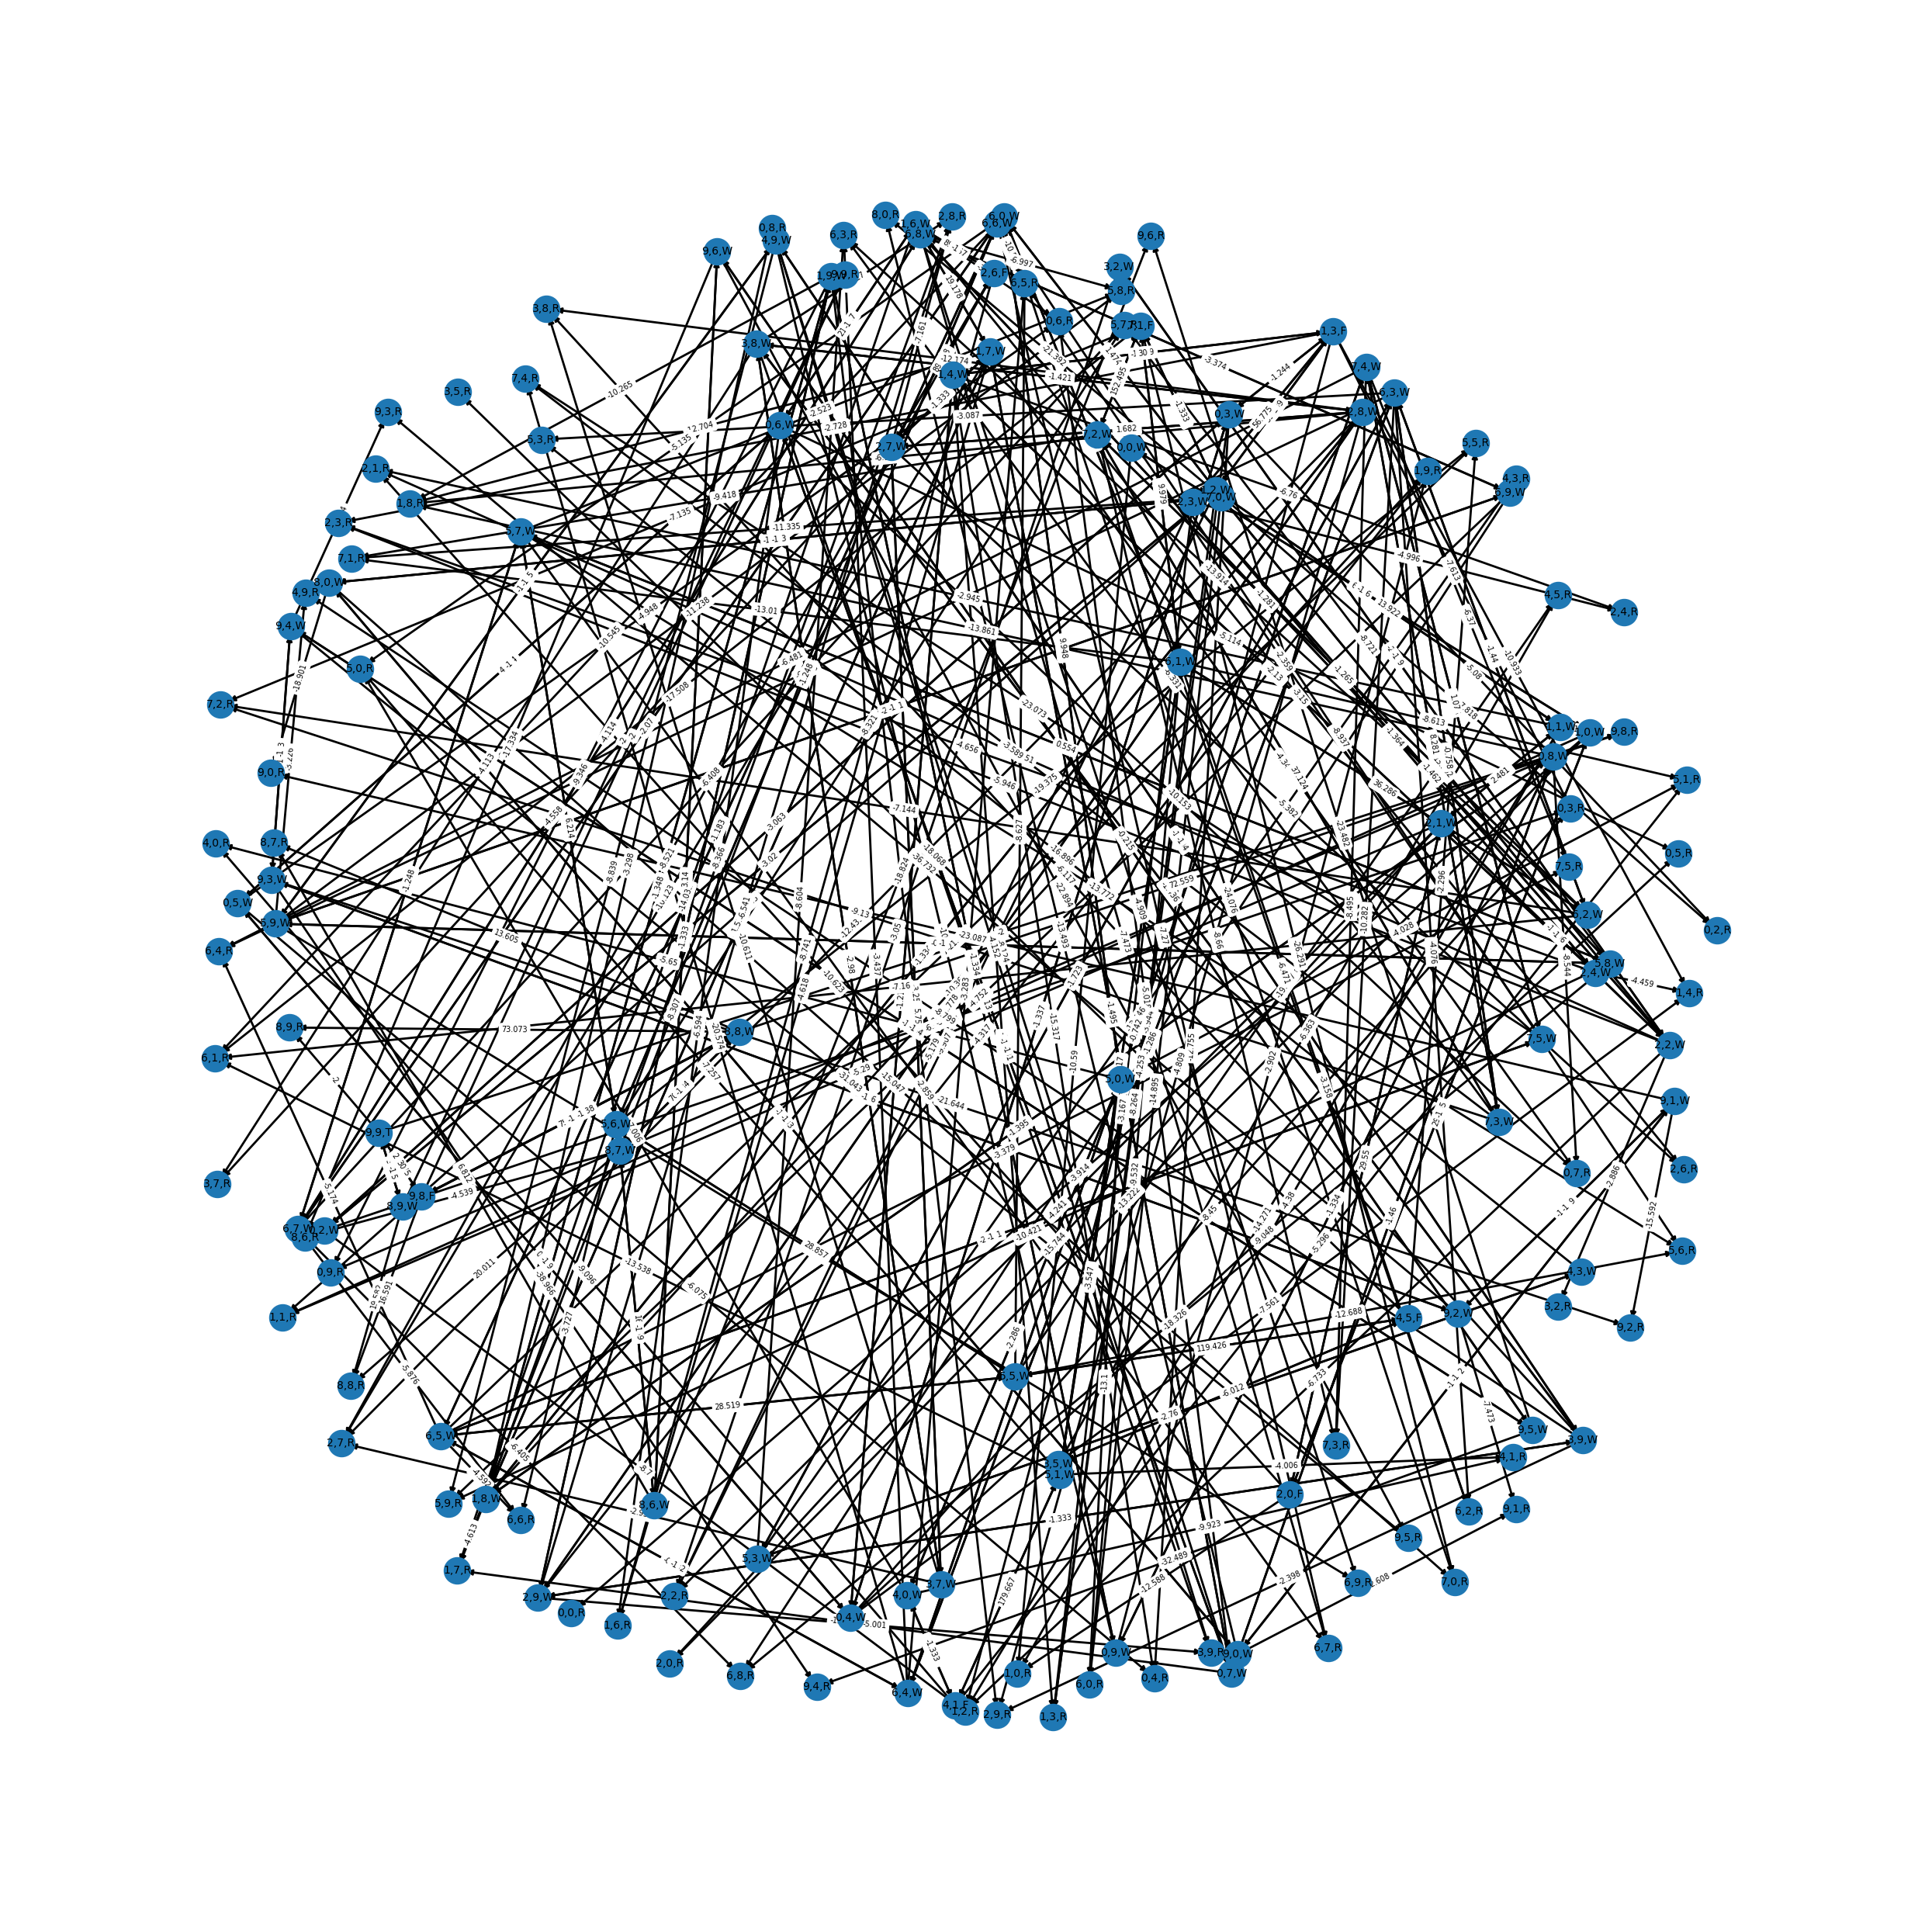

In [17]:
drawGraph(q.getTable())

# Drawing Q-table

In [18]:
from tabulate import tabulate
def getTable(q: Q):
    qtable = q.getTable()
    matrix = [[*key, qtable[key]] for key in qtable]
    return tabulate(matrix, headers=("row", "column", "action", "toBlockType", "award"), tablefmt="double_grid")

print(getTable(q))

╔═══════╦══════════╦══════════╦═══════════════╦═════════════╗
║   row ║   column ║ action   ║ toBlockType   ║       award ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        0 ║ D        ║ W             ║   6.47626   ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        0 ║ D        ║ R             ║ -10.5897    ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        2 ║ R        ║ W             ║  -1.22503   ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        2 ║ R        ║ R             ║  -5.84076   ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        2 ║ D        ║ W             ║  -1         ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        2 ║ D        ║ R             ║  -8.70023   ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        3 ║ R        ║ W             ║  -0.977864  ║
╠═══════

# Trying another maze

In [19]:
M = "\
WWWBFWWWFWFWW \
WFBFBWFWWWWWW \
WWFWWWWWWWWWT"
     
initBoard = list(map(list, M.split()))
initBoard

[['W', 'W', 'W', 'B', 'F', 'W', 'W', 'W', 'F', 'W', 'F', 'W', 'W'],
 ['W', 'F', 'B', 'F', 'B', 'W', 'F', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'F', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'T']]


Testing with 
- gamma = 0.25
- alpha = 0.9

In [20]:
ALPHA = 0.9
GAMMA = 0.25
q = runAlgorithm(700)
reportResult(q)

getting reward -1 [#1] (0, 0) going D to:
getting reward -1 [#2] (1, 0) going R to:
getting reward 30 [#3] (1, 1) going D to:
getting reward -1 [#4] (2, 1) going R to:
getting reward 60 [#5] (2, 2) going R to:
getting reward -1 [#6] (2, 3) going U to:
getting reward 90 [#7] (1, 3) going D to:
getting reward -2 [#8] (2, 3) going R to:
getting reward -1 [#9] (2, 4) going R to:
getting reward -1 [#10] (2, 5) going U to:
getting reward -1 [#11] (1, 5) going R to:
getting reward 120 [#12] (1, 6) going U to:
getting reward -1 [#13] (0, 6) going R to:
getting reward -1 [#14] (0, 7) going R to:
getting reward 150 [#15] (0, 8) going R to:
getting reward -1 [#16] (0, 9) going R to:
getting reward 180 [#17] (0, 10) going R to:
getting reward -1 [#18] (0, 11) going D to:
getting reward -1 [#19] (1, 11) going D to:
getting reward -1 [#20] (2, 11) going R to:
getting reward 300 (2, 12)
Finished with path length:19, flags visited: 6, Total reward: 915, TotalQValueEarned: 1218.5138224907087


Results:
- outcome: sucess
- time: 5.5s
--------------------------------------------------------------------------------------

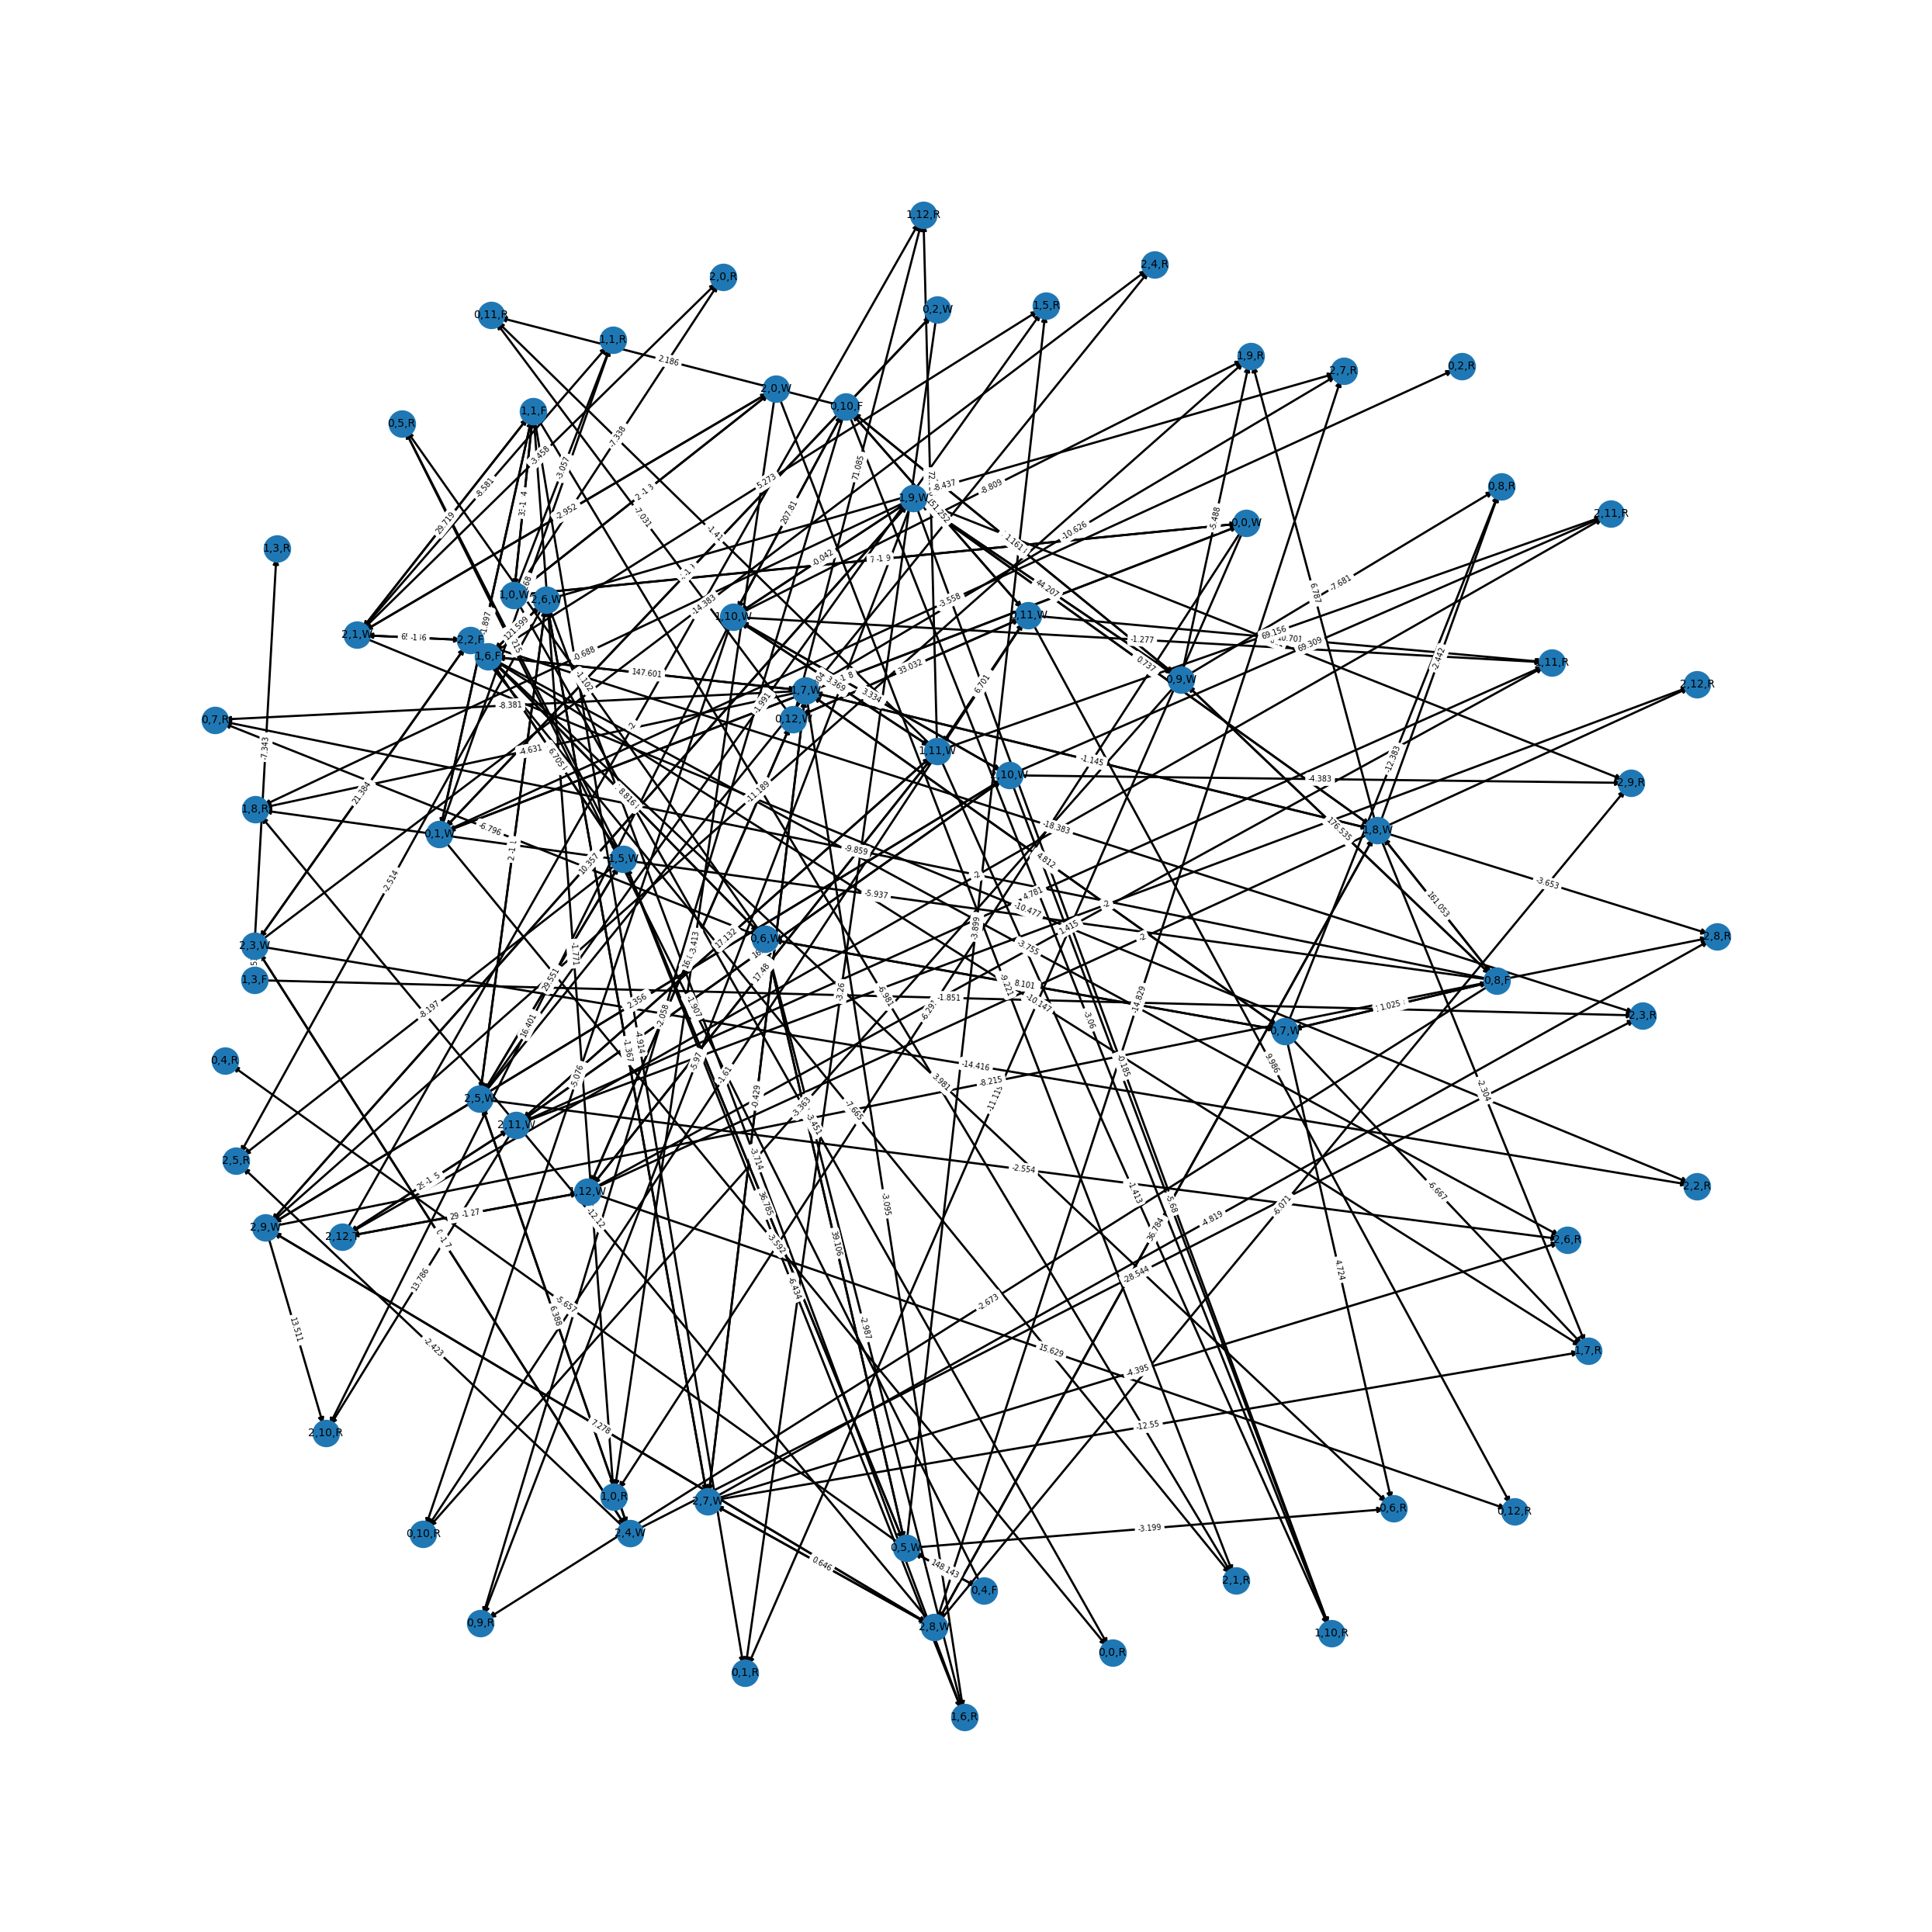

In [21]:
drawGraph(q.getTable())

In [22]:
print(getTable(q))

╔═══════╦══════════╦══════════╦═══════════════╦═════════════╗
║   row ║   column ║ action   ║ toBlockType   ║       award ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        0 ║ R        ║ W             ║  -1.51787   ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        0 ║ R        ║ R             ║ -11.119     ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        0 ║ D        ║ W             ║   7.45853   ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        0 ║ D        ║ R             ║  -6.2912    ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        1 ║ R        ║ W             ║  -2.78977   ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        1 ║ R        ║ R             ║  -3.55771   ║
╠═══════╬══════════╬══════════╬═══════════════╬═════════════╣
║     0 ║        1 ║ L        ║ W             ║  -1         ║
╠═══════

### Another maze ...

In [23]:
M = "\
WWW \
FBB \
WWT"
     
initBoard = list(map(list, M.split()))
initBoard

[['W', 'W', 'W'], ['F', 'B', 'B'], ['W', 'W', 'T']]

In [24]:
ALPHA = 0.9
GAMMA = 0.25
q = runAlgorithm(700)
reportResult(q)

getting reward -1 [#1] (0, 0) going D to:
getting reward 30 [#2] (1, 0) going D to:
getting reward -1 [#3] (2, 0) going R to:
getting reward -1 [#4] (2, 1) going R to:
getting reward 300 (2, 2)
Finished with path length:3, flags visited: 1, Total reward: 327, TotalQValueEarned: 425.2109375


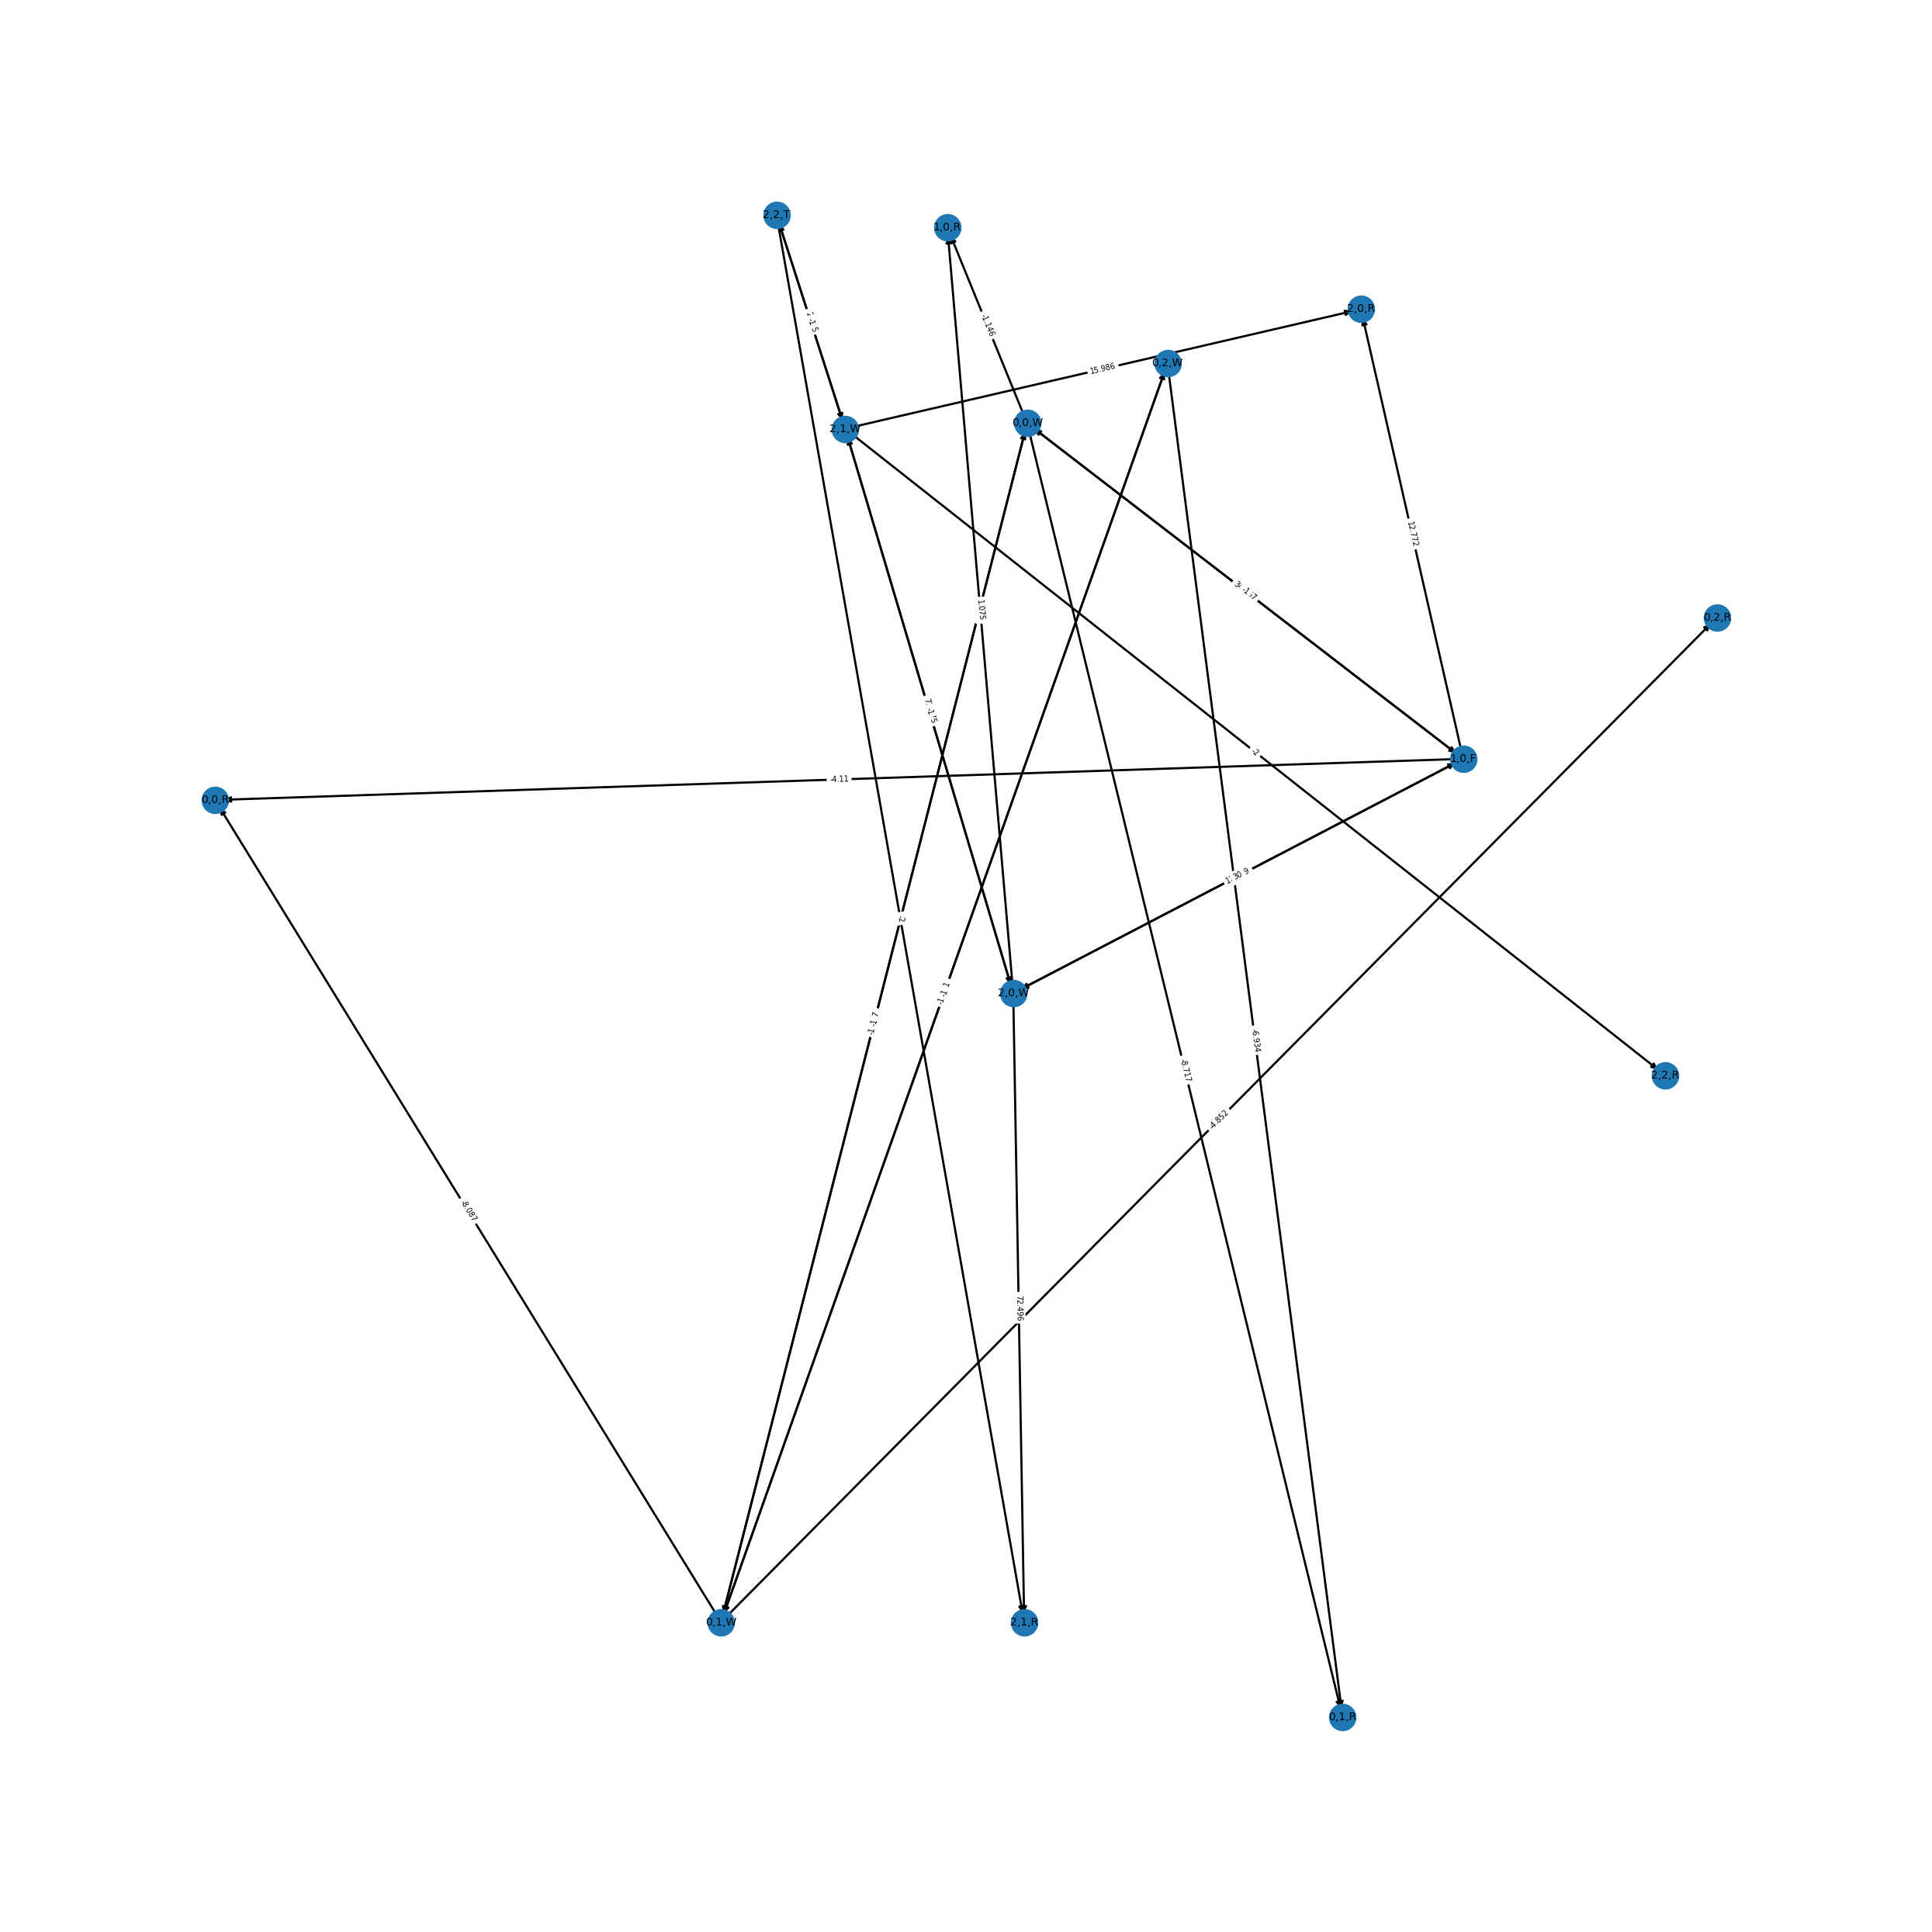

In [25]:
drawGraph(q.getTable())

In [26]:
print(getTable(q))

╔═══════╦══════════╦══════════╦═══════════════╦═══════════╗
║   row ║   column ║ action   ║ toBlockType   ║     award ║
╠═══════╬══════════╬══════════╬═══════════════╬═══════════╣
║     0 ║        0 ║ R        ║ W             ║  -1.39742 ║
╠═══════╬══════════╬══════════╬═══════════════╬═══════════╣
║     0 ║        0 ║ R        ║ R             ║  -8.71674 ║
╠═══════╬══════════╬══════════╬═══════════════╬═══════════╣
║     0 ║        0 ║ D        ║ F             ║  34.3672  ║
╠═══════╬══════════╬══════════╬═══════════════╬═══════════╣
║     0 ║        0 ║ D        ║ R             ║  -1.14615 ║
╠═══════╬══════════╬══════════╬═══════════════╬═══════════╣
║     0 ║        1 ║ R        ║ W             ║  -1.62145 ║
╠═══════╬══════════╬══════════╬═══════════════╬═══════════╣
║     0 ║        1 ║ R        ║ R             ║  -4.8522  ║
╠═══════╬══════════╬══════════╬═══════════════╬═══════════╣
║     0 ║        1 ║ L        ║ W             ║  -1       ║
╠═══════╬══════════╬══════════╬═════════